In [1]:
import glob
import numpy as np
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns 
import sys
import os
import json


[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from session_utils import *
from recalibration_utils import *
from stabilizer_utils import Stabilizer
from sweep_utils import get_subsetDF

sessions_dir  = '/oak/stanford/groups/shenoy/ghwilson/sessions/t5/'
fig_path      = '/home/users/ghwilson/projects/nonstationarities/figures/'

sessions_dict = dict()
sessions_dict['t5.2022.06.08'] = {'stale' : [6, 8], 'stabilizer' : [7, 9], 'PRI-T' : [6, 8]} # day 0 - stale and PRI-T are the same
sessions_dict['t5.2022.06.13'] = {'stale' : [2, 5, 8], 'stabilizer' : [4, 7, 10], 'PRI-T' : [3, 6, 9]}
sessions_dict['t5.2022.06.15'] = {'stale' : [1, 4, 7, 10], 'stabilizer' : [3, 6, 9, 13], 'PRI-T' : [2, 5, 8, 11]}
sessions_dict['t5.2022.06.20'] = {'stale' : [1, 4, 7, 10], 'stabilizer' : [3, 6, 9, 12], 'PRI-T' : [2, 5, 8, 11]}
sessions_dict['t5.2022.06.22'] = {'stale' : [1, 4, 7, 10], 'stabilizer' : [3, 6, 9, 12], 'PRI-T' : [2, 5, 8, 11]}
sessions_dict['t5.2022.07.06'] = {'stale' : [1, 4, 7, 10], 'stabilizer' : [3, 6, 9, 12], 'PRI-T' : [2, 5, 8, 11]}

In [2]:

def loadPickleData(pkl_files):
    
    df_list = list()
    for file in pkl_files:
        with open(file, 'rb') as f:
            df = pickle.load(f)['task_df']
            df_list.append(df)
    
    return df_list
    

In [3]:
import os
from CosineTuning import getAngles
from scipy.io import savemat


cut_secs    = 30
save_folder = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/DataForEwina/'


os.makedirs(save_folder, exist_ok = True)
sessions_data = list()

for session, val in sessions_dict.items():
    session_path = os.path.join(sessions_dir, session, 'Data/TaskData/FittsTask/')
        
    print('\n')
    print(session)
    files = [glob.glob(session_path + f'*block_{x}.pkl')[0] for x in val['stale']]
    datas = loadPickleData(files)

    for i, dat in enumerate(datas):
        
        mat_data = dict()
        
        mat_data['session']    = session
        mat_data['block']      = i
        mat_data['feats']      = np.vstack(dat['neural'])
        mat_data['labels']     = np.vstack(dat['raw_vel'])
        mat_data['targetPos']  = np.vstack(dat['target_pos'])
        mat_data['cursorPos']  = np.vstack(dat['cursor_pos'])
        mat_data['cursorVel']  = np.vstack(dat['cursor_vel'])
        
        stops   = np.asarray(sorted(np.where(dat['state'] >= 2)[0]))
        starts  = np.concatenate([[0], stops[:-1]])
        mat_data['startStops'] = np.vstack([starts, stops]).T
        
        clock_times               = np.asarray([float(x) for x in dat['task_clock']])
        mat_data['excludeTrials'] = clock_times[starts] < cut_secs
        
        ideal_vector             = mat_data['targetPos'] - mat_data['cursorPos']
        mat_data['angularError'] = getAngles(ideal_vector, mat_data['cursorVel'])
        
        save_fname = os.path.join(save_folder, f'{session}_block{i}.mat')
        savemat(save_fname, mat_data)
        



t5.2022.06.08


t5.2022.06.13


t5.2022.06.15


t5.2022.06.20


t5.2022.06.22


t5.2022.07.06


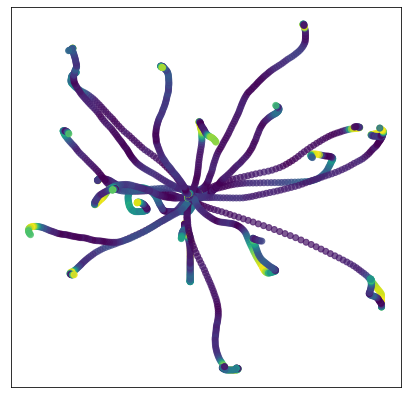

In [93]:
figSize(7, 7)

plt.figure()
ax = plt.gca()

for trl in np.random.choice(mat_data['startStops'].shape[0], 20, replace = False):
    start = mat_data['startStops'][trl, 0]
    stop  = mat_data['startStops'][trl, 1]

    cursor   = mat_data['cursorPos'][start:stop, :]
    target   = mat_data['targetPos'][start + 1, :]
    
    angles   = mat_data['angularError'][start:stop]

    centering = np.copy(cursor[0, :]) 
    cursor   -= centering
    target   -= centering

    r = 0.1
    # radius in display coordinates:
    r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
    # marker size as the area of a circle
    marker_size = np.pi * r_**2

    plt.scatter(cursor[:, 0], cursor[:, 1], c = angles, alpha = 0.7)
   # plt.scatter(target[0], target[1], c = 'g', s = marker_size,)
    plt.xticks([])
    plt.yticks([])